### 05 - Manual QA sampling for baseline classifier

This notebook:
- loads the trained TF-IDF + logistic regression baseline and its decision threshold,
- loads fresh product events from raw JSON exports (recent months),
- applies the same normalization and model to get fashion probabilities,
- samples 50–100 rows into a table with raw name, normalized name, probability, and predicted label
  for manual quality review.

In [2]:
# Setup: find project root, add src to path, import config and preprocessing, load model

from pathlib import Path
import sys
import joblib
import pandas as pd

# Find project root (folder containing "src")
cwd = Path.cwd()
project_root = None
for path in [cwd, *cwd.parents]:
    if (path / "src").is_dir():
        project_root = path
        break

if project_root is None:
    raise FileNotFoundError("Could not find project root containing 'src' folder.")

SRC_DIR = project_root / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

from config import RAW_DATA_DIR, PROCESSED_DATA_DIR
from preprocessing import normalize_text, load_json_file_products

print("Project root:", project_root)
print("RAW_DATA_DIR:", RAW_DATA_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)

# Load the labeled product dataset to know which product_text_norm we have already seen
products_with_splits = pd.read_parquet(PROCESSED_DATA_DIR / "products_with_splits.parquet")
seen_norms = set(products_with_splits["product_text_norm"].astype(str))
print("Number of unique labeled product_text_norm:", len(seen_norms))

# Load the saved baseline model bundle (pipeline + threshold)
model_path = project_root / "models" / "tfidf_logreg_fashion_baseline.joblib"
bundle = joblib.load(model_path)
tfidf_logreg = bundle["pipeline"]
FASHION_THRESHOLD = bundle["threshold"]

print("Loaded baseline model from:", model_path)
print("Using fashion threshold:", FASHION_THRESHOLD)

Project root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
RAW_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/raw
PROCESSED_DATA_DIR: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed
Number of unique labeled product_text_norm: 19767
Loaded baseline model from: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/models/tfidf_logreg_fashion_baseline.joblib
Using fashion threshold: 0.84


In [2]:
# Load fresh product events from recent months and build a candidate pool

import random

qa_months = ["export_shopper=JAN-25", "export_shopper=FEB-25"]  # adjust if you like

def load_month_products(month_name, max_files=10):
    """
    Load up to `max_files` JSON files from one month folder and return
    a DataFrame with product_text_raw and product_text_norm.
    """
    month_dir = RAW_DATA_DIR / month_name
    if not month_dir.is_dir():
        raise FileNotFoundError(f"Month folder not found: {month_dir}")

    json_paths = sorted(month_dir.glob("*.json"))
    if not json_paths:
        raise FileNotFoundError(f"No JSON files found in {month_dir}")

    # Take a small random subset of files for QA to keep it light
    random.seed(42)
    chosen_files = random.sample(json_paths, min(max_files, len(json_paths)))
    print(f"{month_name}: loading {len(chosen_files)} of {len(json_paths)} JSON files")

    dfs = []
    for p in chosen_files:
        df_file = load_json_file_products(p)
        dfs.append(df_file)

    if not dfs:
        return pd.DataFrame()

    df_month = pd.concat(dfs, ignore_index=True)

    # Ensure we have raw and normalized text columns
    if "product_text_raw" not in df_month.columns:
        df_month["product_text_raw"] = df_month["remove_amazon"].astype(str)
    if "product_text_norm" not in df_month.columns:
        df_month["product_text_norm"] = df_month["product_text_raw"].apply(normalize_text)

    df_month["month"] = month_name
    return df_month[["month", "product_text_raw", "product_text_norm"]]


all_candidates = []
for m in qa_months:
    df_m = load_month_products(m, max_files=10)
    print(m, "rows before filtering:", len(df_m))
    all_candidates.append(df_m)

candidates = pd.concat(all_candidates, ignore_index=True)
print("Combined candidate rows:", len(candidates))

# Drop rows with empty or NaN normalized text
candidates = candidates.dropna(subset=["product_text_norm"])
candidates = candidates[candidates["product_text_norm"].str.strip() != ""]
print("After dropping empty normalized text:", len(candidates))

# Remove any product_text_norm that we already had labels for
candidates = candidates[~candidates["product_text_norm"].isin(seen_norms)]
print("After removing already-labeled products:", len(candidates))

candidates.head(10)

export_shopper=JAN-25: loading 10 of 128 JSON files
export_shopper=JAN-25 rows before filtering: 180390
export_shopper=FEB-25: loading 10 of 128 JSON files
export_shopper=FEB-25 rows before filtering: 22442
Combined candidate rows: 202832
After dropping empty normalized text: 202832
After removing already-labeled products: 201541


,month,product_text_raw,product_text_norm
0,export_shopper=JAN-25,(2 pack) Better Homes & Gardens Canister - 6.2...,2 pack better homes gardens canister 6 2 cup f...
1,export_shopper=JAN-25,"Kentucky Reserve, Pork, Whole Hickory Ham, 7.5...",kentucky reserve pork whole hickory ham 7 5 9 ...
2,export_shopper=JAN-25,Baxton Studio Lanny Modern and Contemporary Fa...,baxton studio lanny modern and contemporary fa...
3,export_shopper=JAN-25,Pooboo Recumbent Exercise Bicycles for Adults ...,pooboo recumbent exercise bicycles for adults ...
4,export_shopper=JAN-25,"[""""12-Piece Pounce Toy Gift Box – Pounce on It...",12 piece pounce toy gift box pounce on it asso...
5,export_shopper=JAN-25,"Wireless Charger,10W Max Fast Wireless Chargin...",wireless charger 10w max fast wireless chargin...
6,export_shopper=JAN-25,Orion XEQ-X7 7-Band Graphic Equalizer w/ Front...,orion xeq x7 7 band graphic equalizer w front ...
7,export_shopper=JAN-25,Tamagotchi Original Milk and Cookies Digital Pet,tamagotchi original milk and cookies digital pet
8,export_shopper=JAN-25,TASHHAR Reading Glasses Hanging Folding Magnet...,tashhar reading glasses hanging folding magnet...
9,export_shopper=JAN-25,Honey Smoked Salmon (TM) Original 8oz,honey smoked salmon tm original 8oz


In [3]:
# Sample a subset for manual QA, run the model, and build a review table

n_samples = 100  # change to 50 if you want fewer
if len(candidates) < n_samples:
    n_samples = len(candidates)

qa_sample = candidates.sample(n=n_samples, random_state=42).copy()

# Run model
probs = tfidf_logreg.predict_proba(qa_sample["product_text_norm"].values)[:, 1]
pred_labels = (probs >= FASHION_THRESHOLD).astype(int)

qa_sample["prob_fashion"] = probs
qa_sample["pred_label"] = pred_labels
qa_sample["pred_label_str"] = qa_sample["pred_label"].map({0: "non-fashion", 1: "fashion"})

# Sort by probability, highest fashion first (optional)
qa_sample = qa_sample.sort_values("prob_fashion", ascending=False).reset_index(drop=True)

print("Manual QA sample shape:", qa_sample.shape)
qa_sample.head(20)

Manual QA sample shape: (100, 6)


,month,product_text_raw,product_text_norm,prob_fashion,pred_label,pred_label_str
0,export_shopper=JAN-25,Kitecy Necklaces & Pendants Clearance! 925 Ste...,kitecy necklaces pendants clearance 925 sterli...,0.994923,1,fashion
1,export_shopper=JAN-25,Under Armour Girls' Freedom Flag T-Shirt,under armour girls freedom flag t shirt,0.982508,1,fashion
2,export_shopper=JAN-25,"[""""PRETTYGARDEN Women's 2 Piece Pullover Sweat...",prettygarden women s 2 piece pullover sweater ...,0.982499,1,fashion
3,export_shopper=JAN-25,"Women's Maternity Scrub Pants, Sizes XS-XXXL",women s maternity scrub pants sizes xs xxxl,0.975873,1,fashion
4,export_shopper=JAN-25,PatPat Mommy and Me 100% Cotton Matching Dress...,patpat mommy and me 100 cotton matching dresse...,0.975234,1,fashion
5,export_shopper=JAN-25,CREATMO US Women's Plus Size Puffer Jacket Wat...,creatmo us women s plus size puffer jacket wat...,0.964701,1,fashion
6,export_shopper=JAN-25,Crocs Men's LiteRide 360 Pacer Lace-up Water S...,crocs men s literide 360 pacer lace up water s...,0.944401,1,fashion
7,export_shopper=JAN-25,14K Gold Graduated Hoop Huggie Earring,14k gold graduated hoop huggie earring,0.930230,1,fashion
8,export_shopper=JAN-25,"JanSport Superbreak Backpack - Durable, Lightw...",jansport superbreak backpack durable lightweig...,0.925549,1,fashion
9,export_shopper=JAN-25,BeautyWill Custom Safety Vest Logo Class 2 Hig...,beautywill custom safety vest logo class 2 hig...,0.923011,1,fashion


In [4]:
# Save QA sample to CSV for external review (Excel, etc.)

qa_path = PROCESSED_DATA_DIR / "manual_qa_baseline_predictions.csv"
qa_sample.to_csv(qa_path, index=False)
print("Saved manual QA sample to:", qa_path)

Saved manual QA sample to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/processed/manual_qa_baseline_predictions.csv


Manual QA sample size: 100
Accuracy vs manual labels: 0.9000

Classification report (manual_label as truth):
              precision    recall  f1-score   support

 non-fashion     1.0000    0.8851    0.9390        87
     fashion     0.5652    1.0000    0.7222        13

    accuracy                         0.9000       100
   macro avg     0.7826    0.9425    0.8306       100
weighted avg     0.9435    0.9000    0.9108       100

Confusion matrix (rows = manual label, cols = model prediction):
[[77 10]
 [ 0 13]]


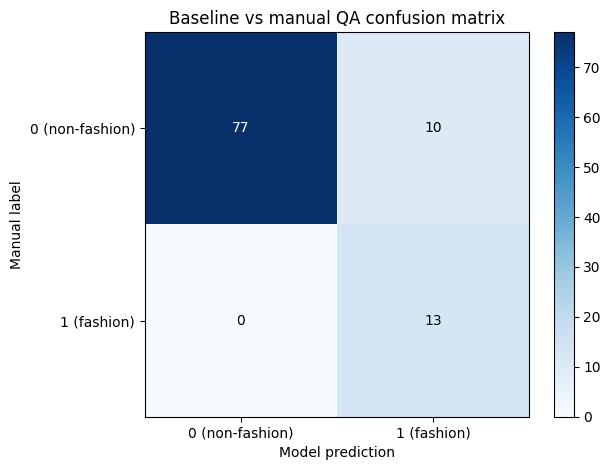

In [3]:
# Evaluate baseline vs manual QA labels and plot a confusion matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the QA file (or skip this if qa_sample is already in memory with manual_label)
qa_path = PROCESSED_DATA_DIR / "manual_qa_baseline_predictions.csv"
qa_df = pd.read_csv(qa_path)

# Drop rows without manual labels, just in case
qa_df = qa_df.dropna(subset=["manual_label"])

y_true = qa_df["manual_label"].astype(int).values
y_pred = qa_df["pred_label"].astype(int).values

# Basic metrics
acc = accuracy_score(y_true, y_pred)
print(f"Manual QA sample size: {len(y_true)}")
print(f"Accuracy vs manual labels: {acc:.4f}\n")

print("Classification report (manual_label as truth):")
print(
    classification_report(
        y_true,
        y_pred,
        labels=[0, 1],
        target_names=["non-fashion", "fashion"],
        digits=4,
    )
)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion matrix (rows = manual label, cols = model prediction):")
print(cm)

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Baseline vs manual QA confusion matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
plt.yticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
plt.xlabel("Model prediction")
plt.ylabel("Manual label")

text_threshold = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            str(cm[i, j]),
            ha="center",
            va="center",
            color="white" if cm[i, j] > text_threshold else "black",
        )

plt.tight_layout()
plt.grid(False)
plt.show()

#### The results from manual QA on a sample of 100 rows is as follows but please note that I dont take this accuracy too literally as the product names vary a lot and 100 is not just a big enough sample 

#### On a hand-labeled QA sample of 100 recent products, the baseline achieved ~90% accuracy; we observed some non-fashion items tagged as fashion, which motivated the later BERT model and careful threshold tuning